# Laboratory work 6: differential equations

---

## Work objective:

Solve a system of ordinary differential equations (ODEs) by:

1) Runge-Kutta methods;
2) Adams' methods;
3) Backward differentiation formula.

The example to which these methods were applied is well-known Van der Pol equation

\begin{equation*}
    \ddot{x} + \mu(x^2 - 1)\dot{x} + x = 0
\end{equation*}

We have to transform the equation of the 2nd order into a system of equations of the 1st order to
be able to apply aforementioned methods. It may be done the following way:

\begin{cases}
    \dot{z} = y \\
    \dot{y} = \mu(1 - z^2)y + z
\end{cases}

Another thing worth mentioning is that numerical methods can solve Cauchy problem but not find the
general solution. It means we should also provide initial values of functions $z(t)$ and $y(t)$:

\begin{cases}
    z(0) = 2 \\
    y(0) = 0\
\end{cases}

Let's also say that we won't try to find the solution for $t \in [0; +\infty)$, but only for
$t \in [0; 100]$.

## Imports

In [444]:
import numpy as np
from matplotlib import pyplot as plt

## Runge-Kutta methods

In [445]:
"""
dx/dt = f(t, x), t in [t_1; t_2], x in R^n
x(t_1) = x_0
-------
N:       number of intervals [t_1; t_2] is divided into
A, B, C: parts of Butcher tableau;
"""
def Explicit_Runge_Kutta(f, x_0, t_1, t_2, N, A, B, C):

    order = len(B)
    if order != len(C):
        raise RuntimeError("The size of B-part of Butcher tableau mismatches the size of C-part")
    elif C[0] != 0:
        raise RuntimeError("The first element of C shall equal to 0")

    t = np.linspace(t_1, t_2, num = N + 1, endpoint = True)
    dt = (t_2 - t_1) / (N + 1)

    dim = len(x_0)
    x = np.empty(shape=(N + 1, dim))
    x[0] = x_0

    k = np.empty(shape=(order, dim))

    for n in range(N):
        for i in range(order):
            k[i] = f(t[n] + dt * C[i], x[n] + dt * sum(A[i - 1][j] * k[j] for j in range(i)))
        x[n + 1] = x[n] + sum(B[j] * k[j] for j in range(order)) * dt

    return t, x

We will use the following Butcher tableau for a method of the 4th order:

| 0 |   |   |   |   |
|:-:|:-:|:-:|:-:|:-:|
|1/2|1/2|   |   |   |
|1/2| 0 |1/2|   |   |
| 1 | 0 | 0 | 1 |   |
|   |1/6|2/6|2/6|1/6|

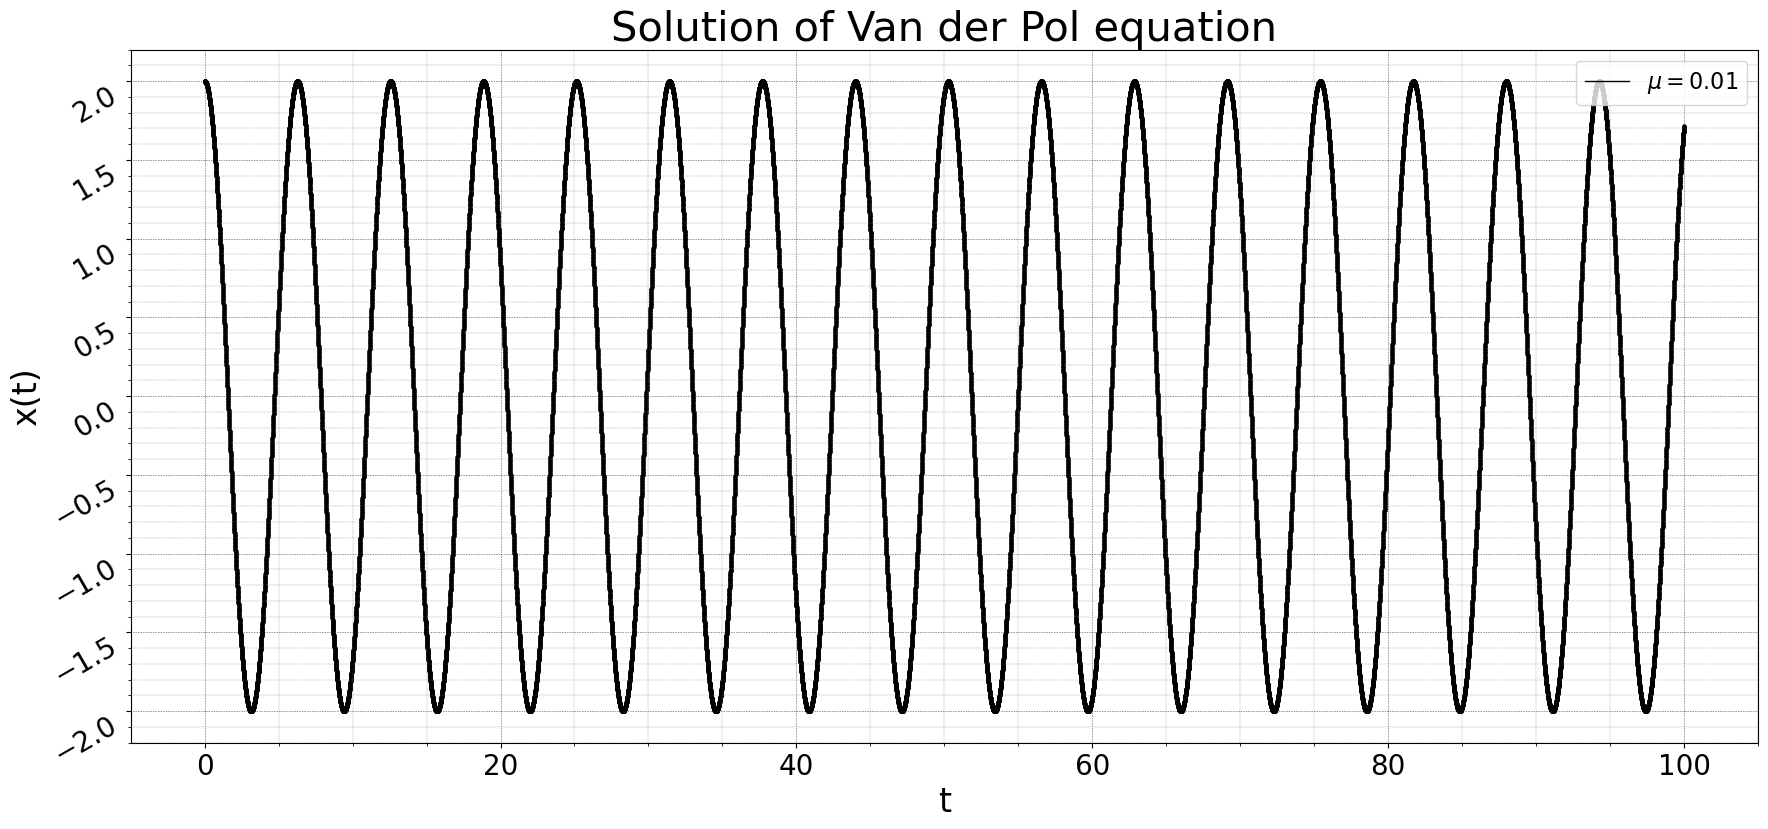

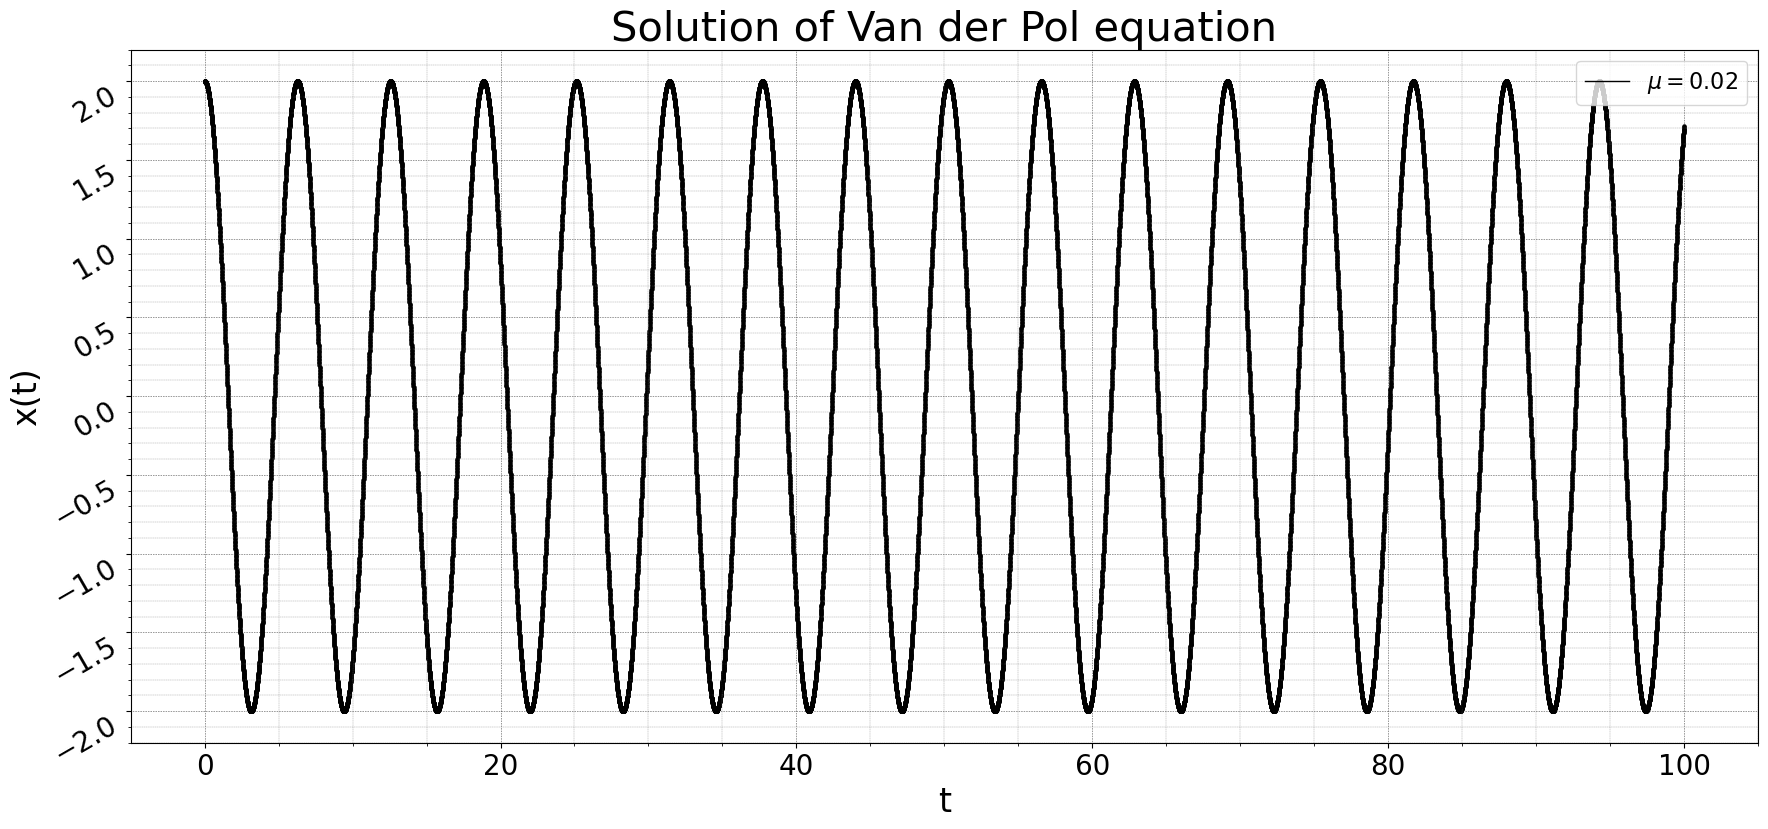

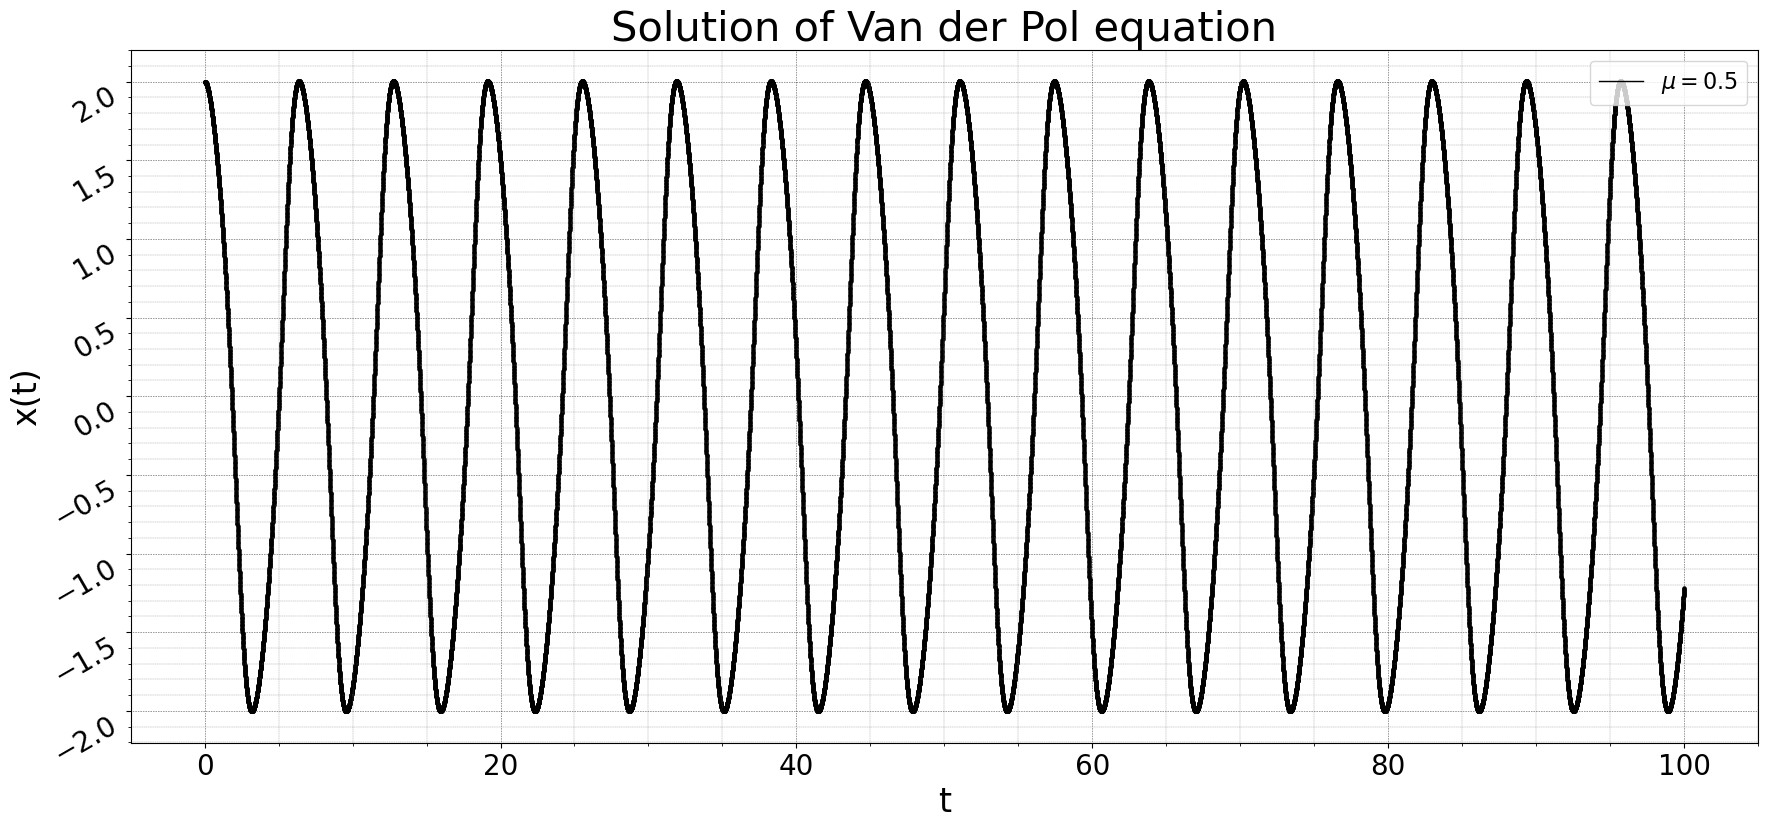

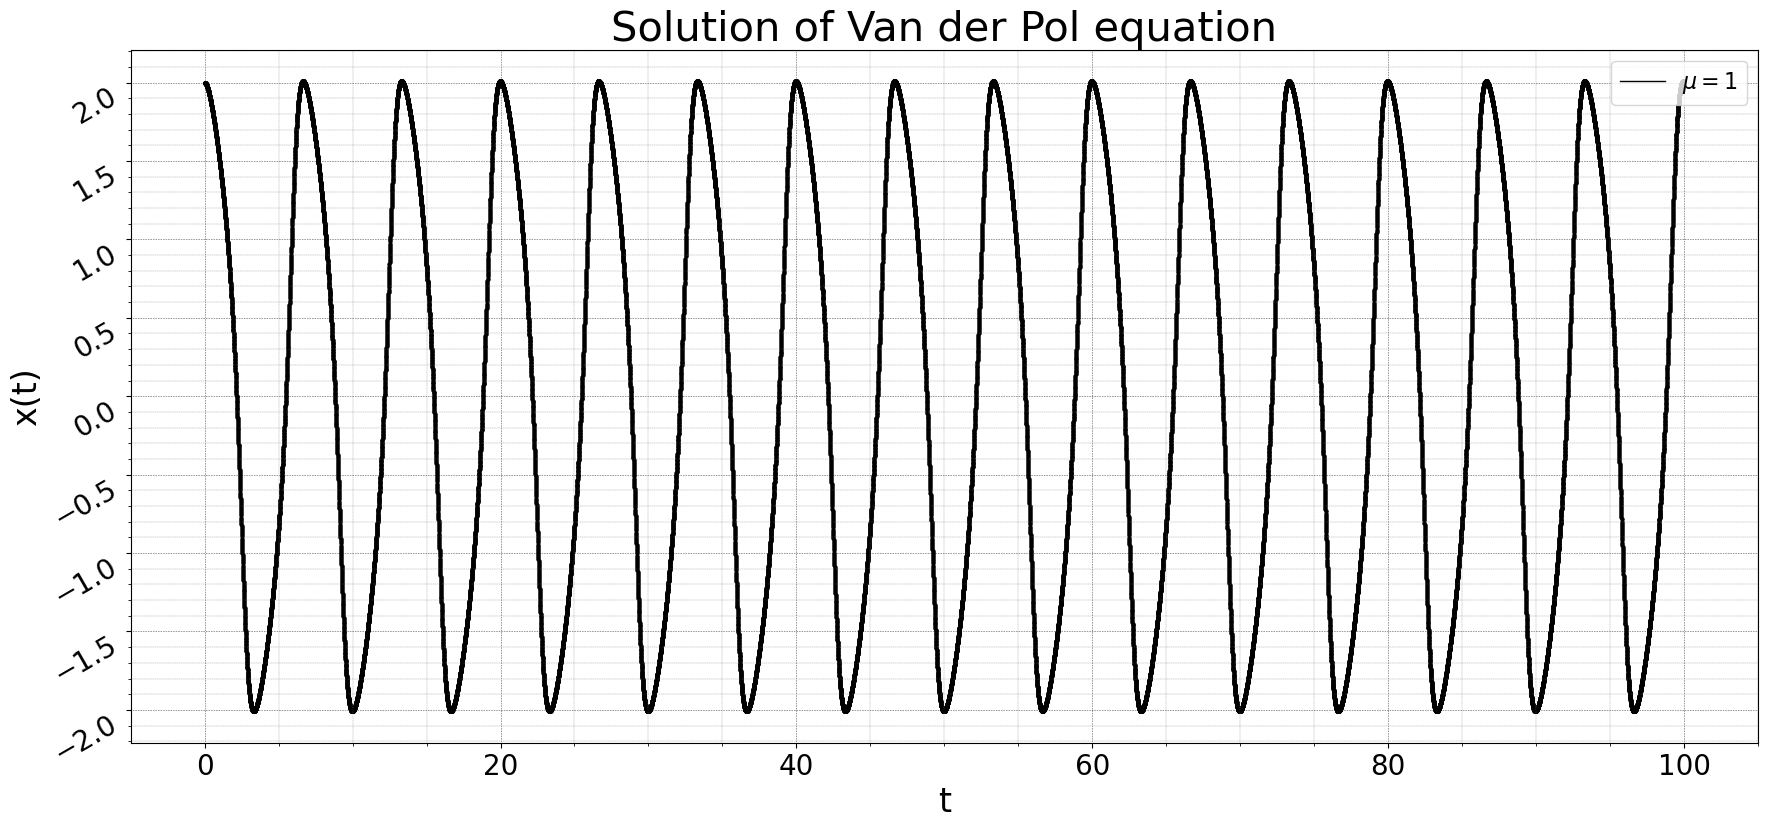

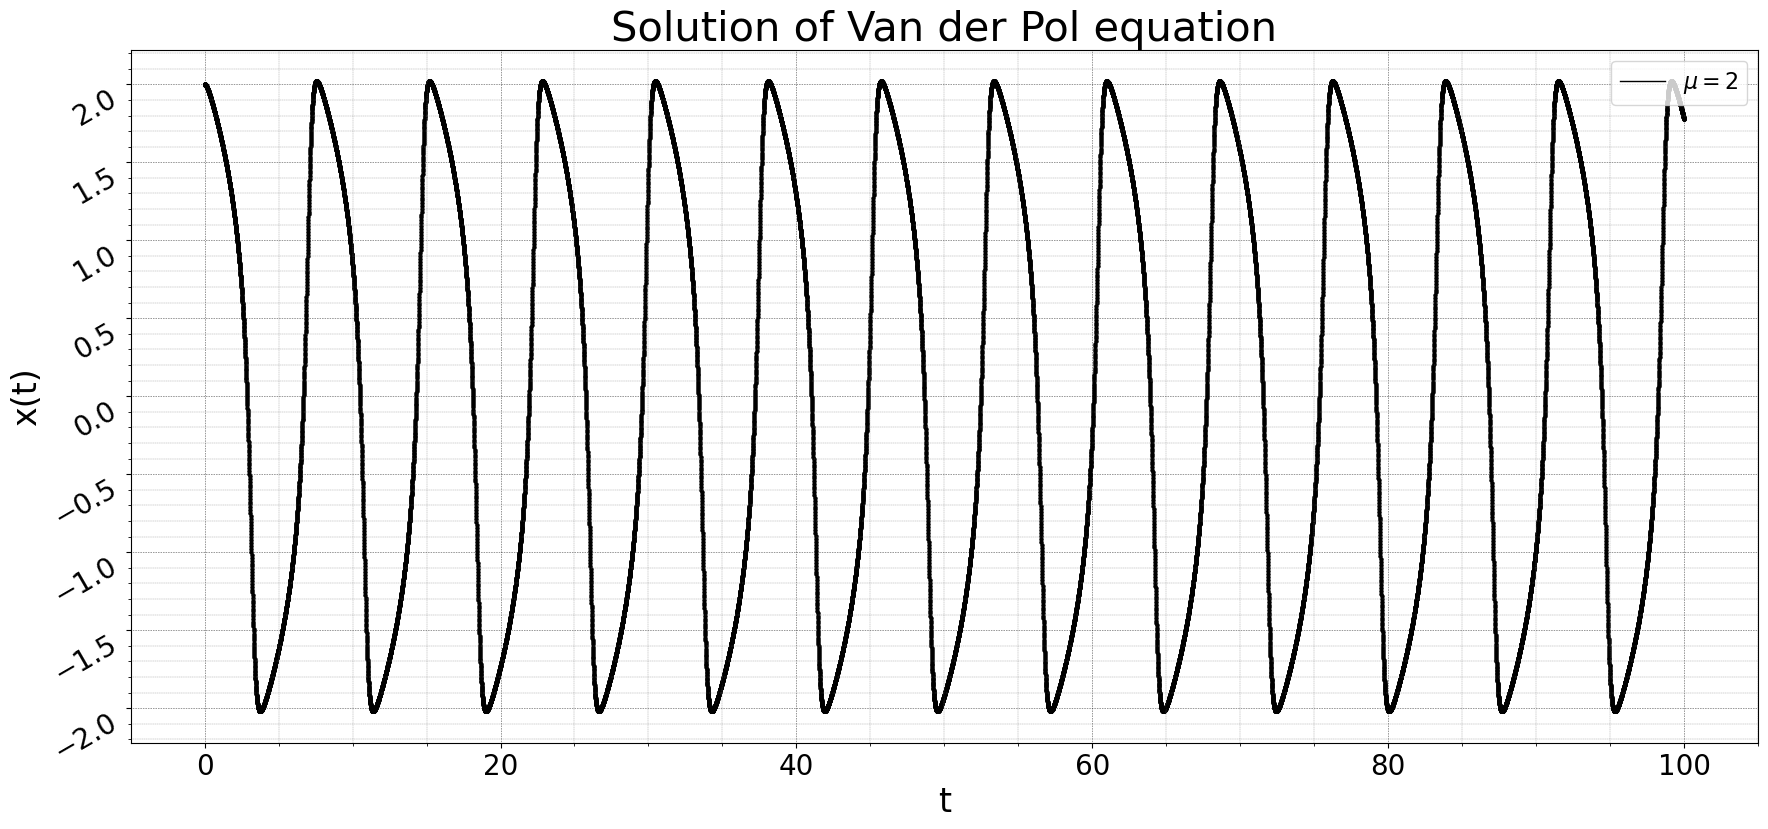

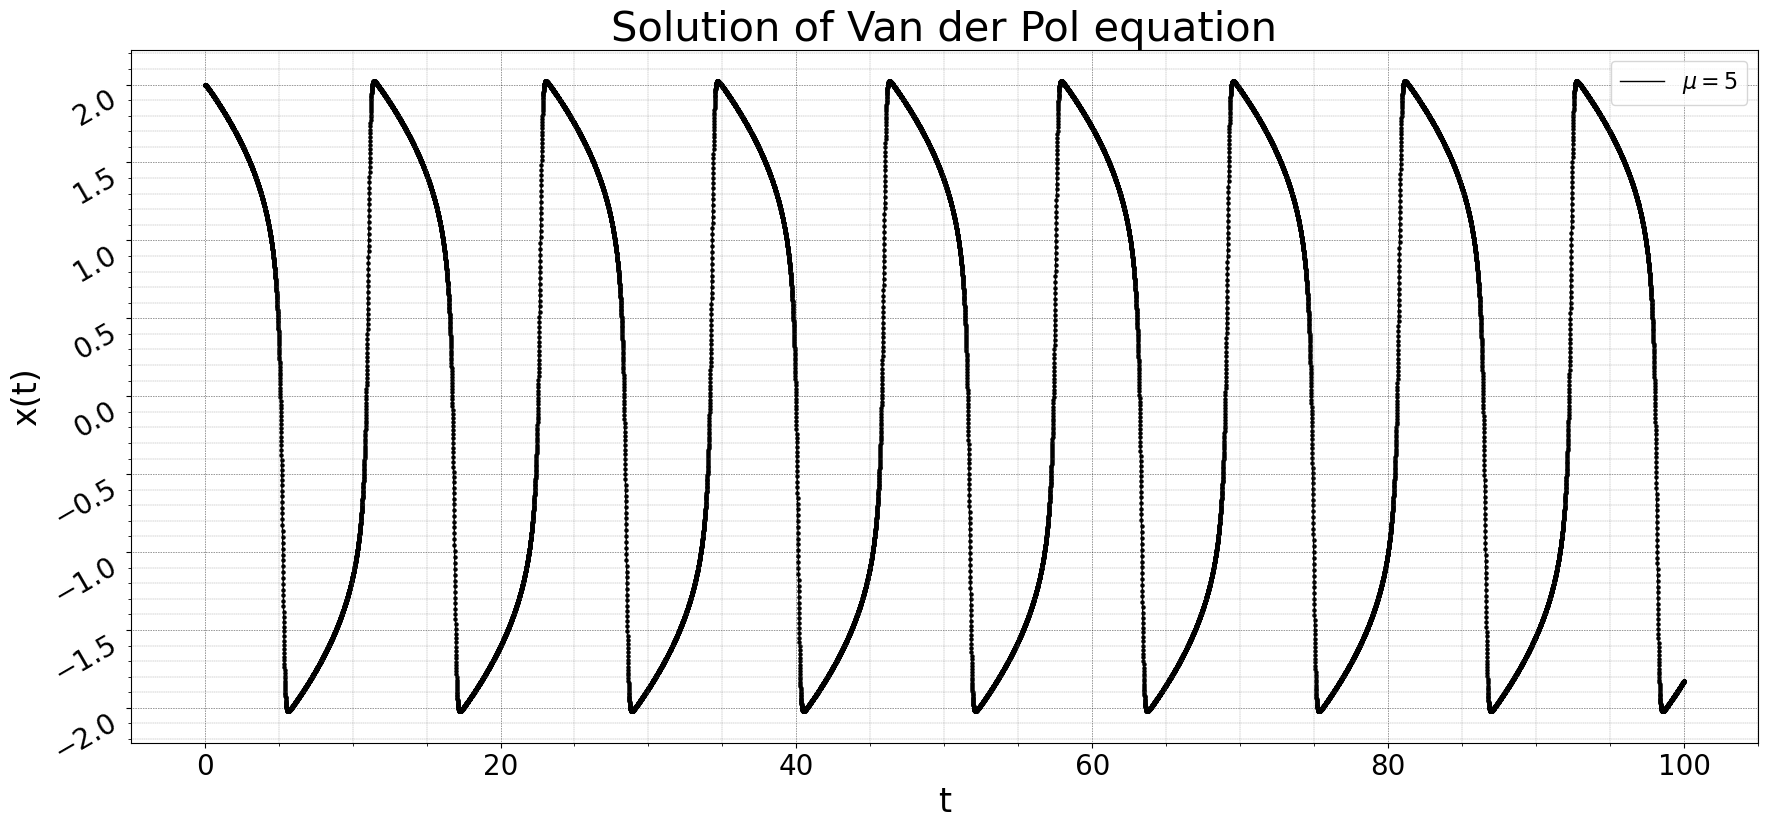

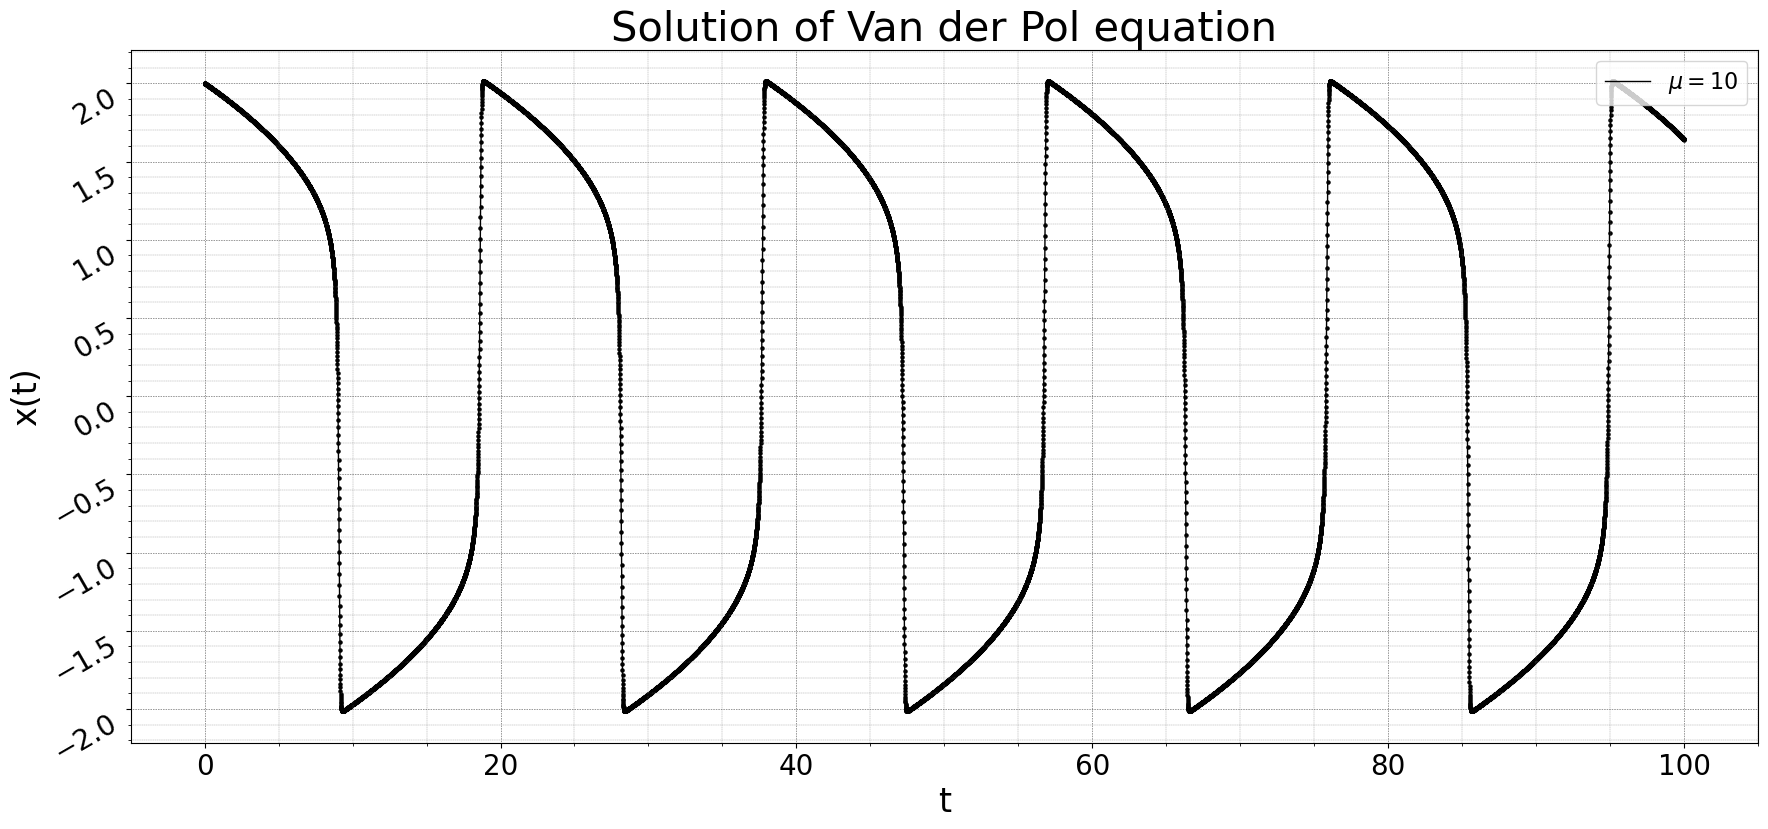

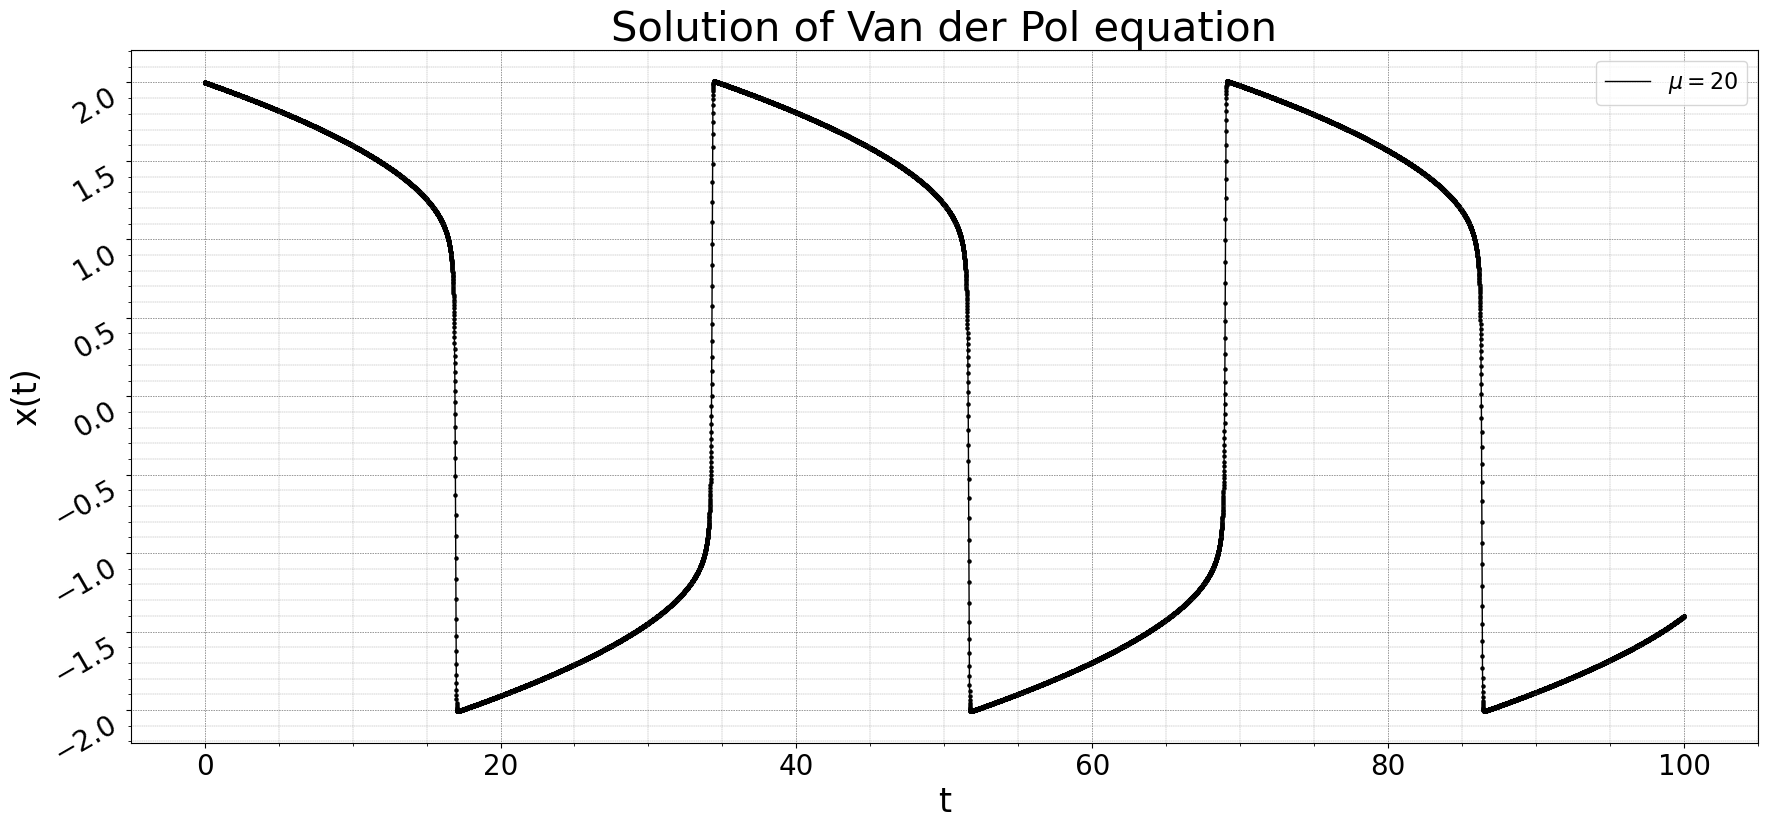

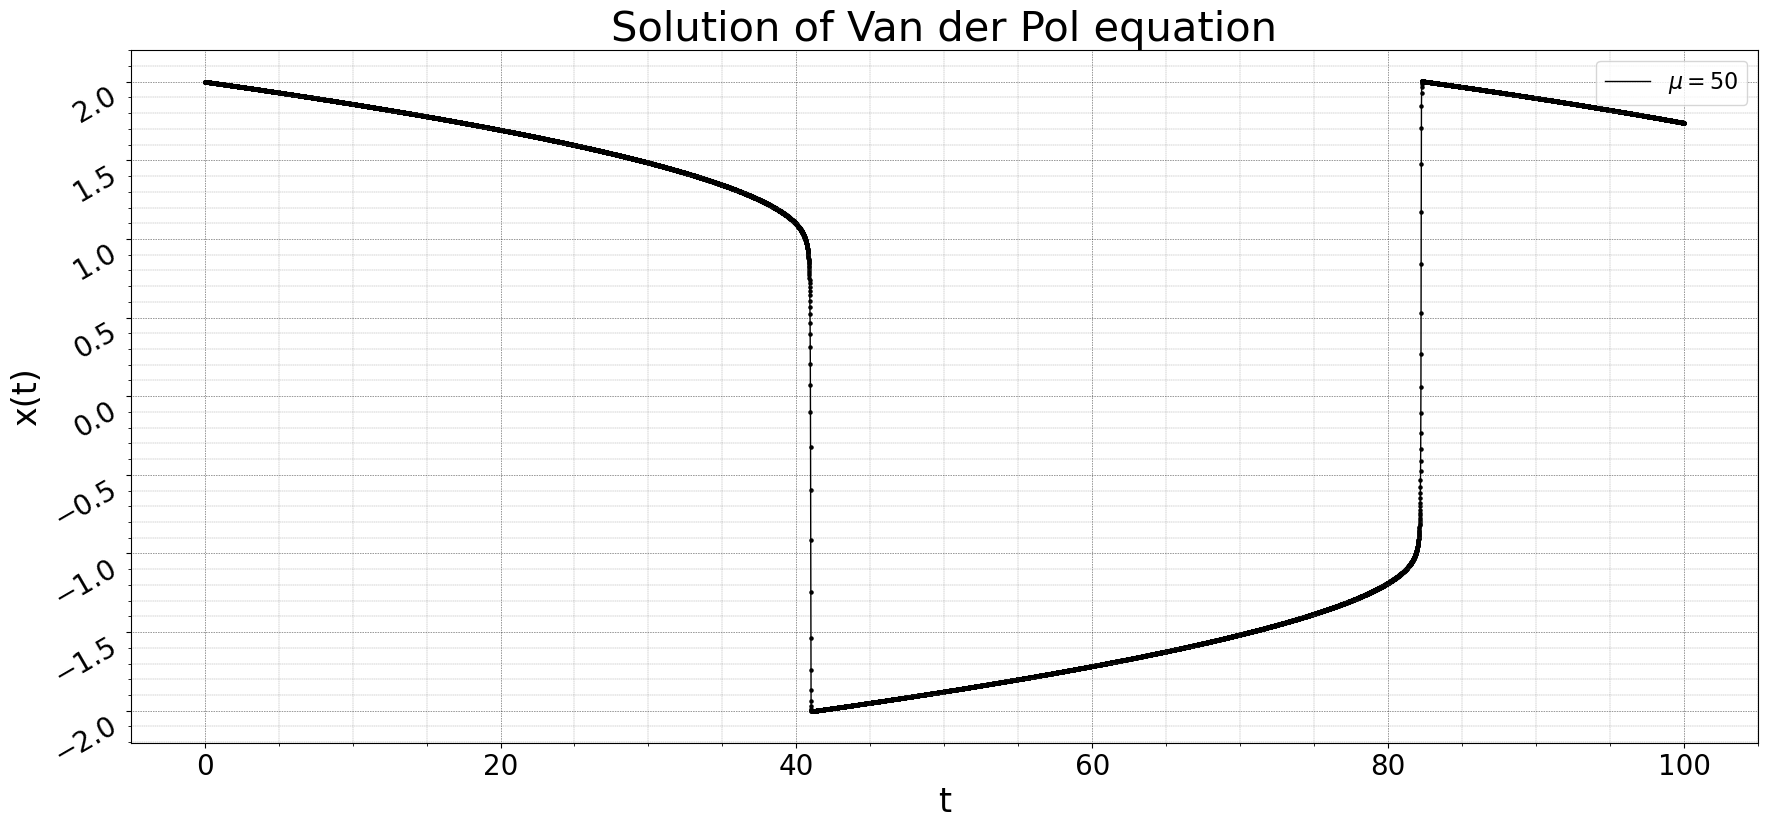

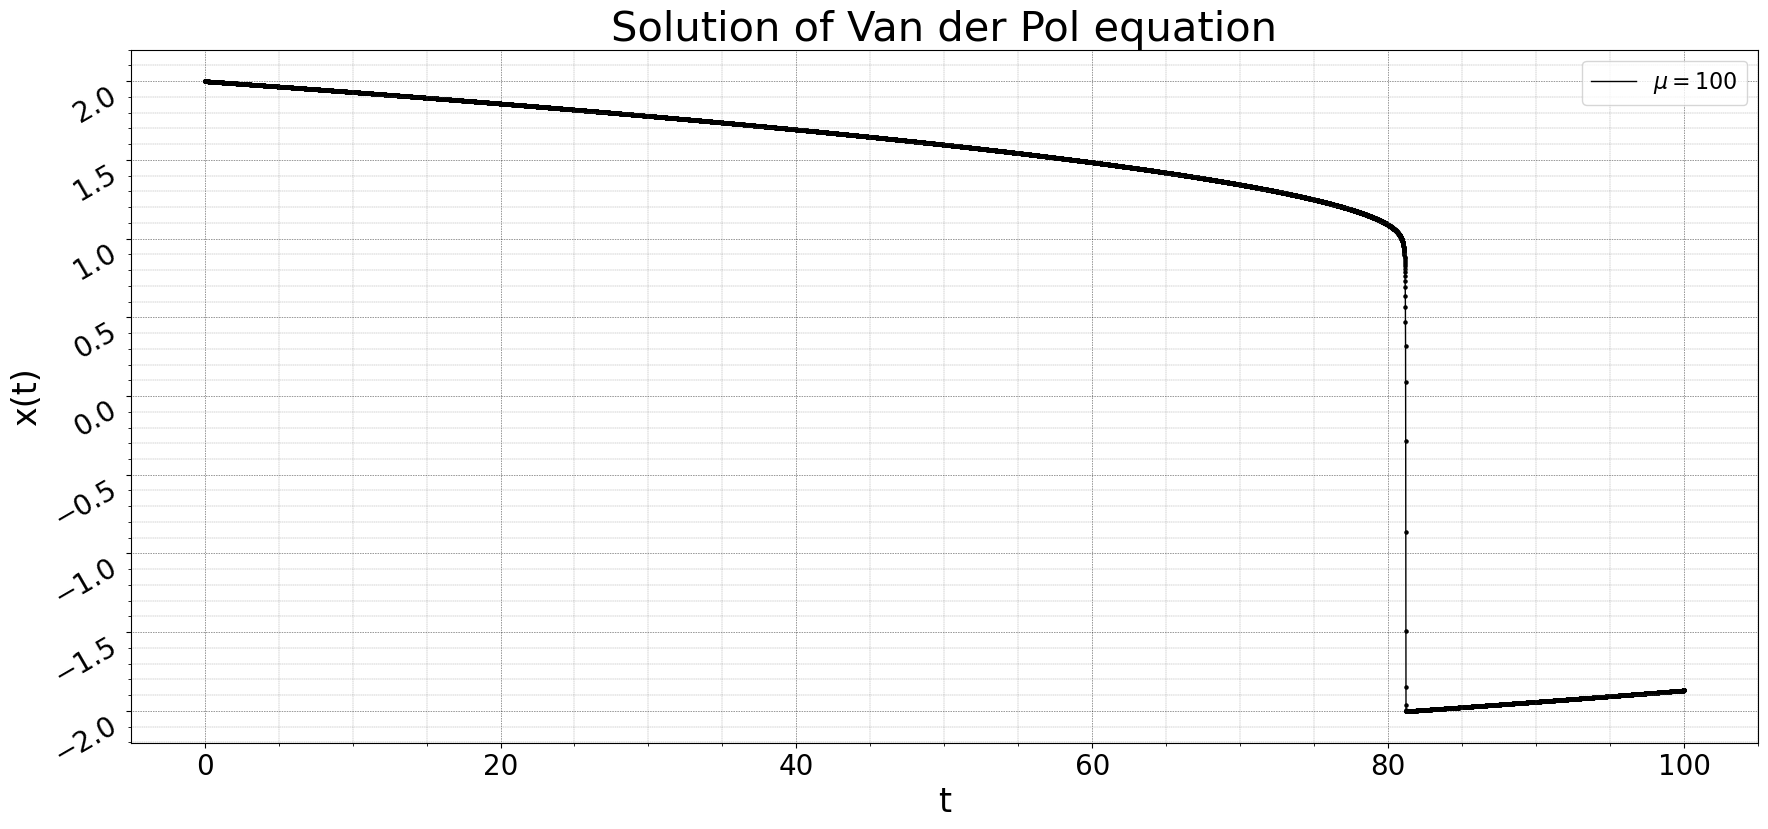

In [446]:
a = [[0.5],
     [0.0, 0.5],
     [0.0, 0.0, 1.0]]
b = np.array([1.0/6.0, 2.0/6.0, 2.0/6.0, 1.0/6.0])
c = np.array([0.0, 0.5, 0.5, 1.0])

def draw(mu):

    F = lambda t, x: np.array([x[1], mu * (1 - x[0]**2) * x[1] - x[0]])

    t, x = Explicit_Runge_Kutta(F, x_0=[2, 0], t_1=0, t_2=100, N=20000, A=a, B=b, C=c)
    x = np.delete(x, 1, 1)

    plt.figure(figsize = (21, 9), dpi = 100)
    plt.title("Solution of Van der Pol equation", fontsize = 30)

    plt.xlabel("t", fontsize = 24)
    plt.xticks(fontsize =  20, ha = "center", va = "top")

    plt.ylabel("x(t)", fontsize = 24)
    plt.yticks(fontsize = 20, rotation = 30, ha = "right", va = "top")

    plt.scatter(t, x, s  = 5, color = "black")
    plt.plot(t, x, linewidth = 1, color = "black", label = f"$\\mu = {mu}$")

    plt.legend(loc = "upper right", fontsize = 16)

    plt.grid (color = "black", linewidth = 0.45, linestyle = "dotted")
    plt.minorticks_on()
    plt.grid (which = "minor", color = "grey", linewidth = 0.25, linestyle = "dashed")

    plt.show()

for mu in [0.01, 0.02, 0.5, 1, 2, 5, 10, 20, 50, 100]:
    draw(mu)